In [2]:
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url

In [3]:
pip install ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 101.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url

In [5]:
from ddgs import DDGS
from pathlib import Path
from time import sleep
from tqdm import tqdm

from fastai.vision.all import *
from fastai.vision.widgets import *
from ddgs import DDGS

def search_images(query, max_results=30):
    with DDGS(timeout=30) as ddgs:
        results = ddgs.images(
            query,
            max_results=max_results,
            safesearch="off",
            region="wt-wt"
        )
    return [r["image"] for r in results if "image" in r]

avions = ['Dassault Rafale', 'Piper Cub', 'Boeing 737', 'McDonnell Douglas C-17', 'Citation XL']
path = Path('avions')

for b in tqdm(avions):
    dest = path / b
    dest.mkdir(exist_ok=True, parents=True)

    download_images(dest, urls=search_images(f'photo {b}'))
    sleep(10)

    download_images(dest, urls=search_images(f'photo {b} from above'))
    sleep(10)

    download_images(dest, urls=search_images(f'photo {b} from below'))
    sleep(10)

    resize_images(dest, max_size=400)


100%|██████████| 5/5 [03:48<00:00, 45.76s/it]


In [6]:
from fastai.vision.utils import verify_images

fns = get_image_files(path)
failed = verify_images(fns)
failed


(#1) [Path('avions/Citation XL/417f1cc6-492a-4a69-8698-5ddc1502e115.jpg')]

In [7]:
failed.map(Path.unlink)

(#1) [None]

In [8]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed = 18),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

In [9]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224))
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.483567,0.723358,0.739726,00:50


epoch,train_loss,valid_loss,accuracy,time
0,1.019540,0.340308,0.890411,01:05
1,0.721994,0.121208,0.958904,01:06
2,0.503045,0.091145,0.972603,01:06
3,0.386178,0.079134,0.972603,01:06
4,0.307484,0.078852,0.972603,01:06


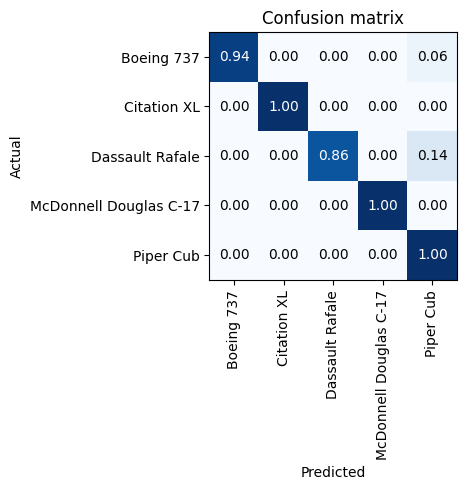

In [10]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(normalize = True)

In [11]:
learn.export('airplane_recognition_model.pkl')


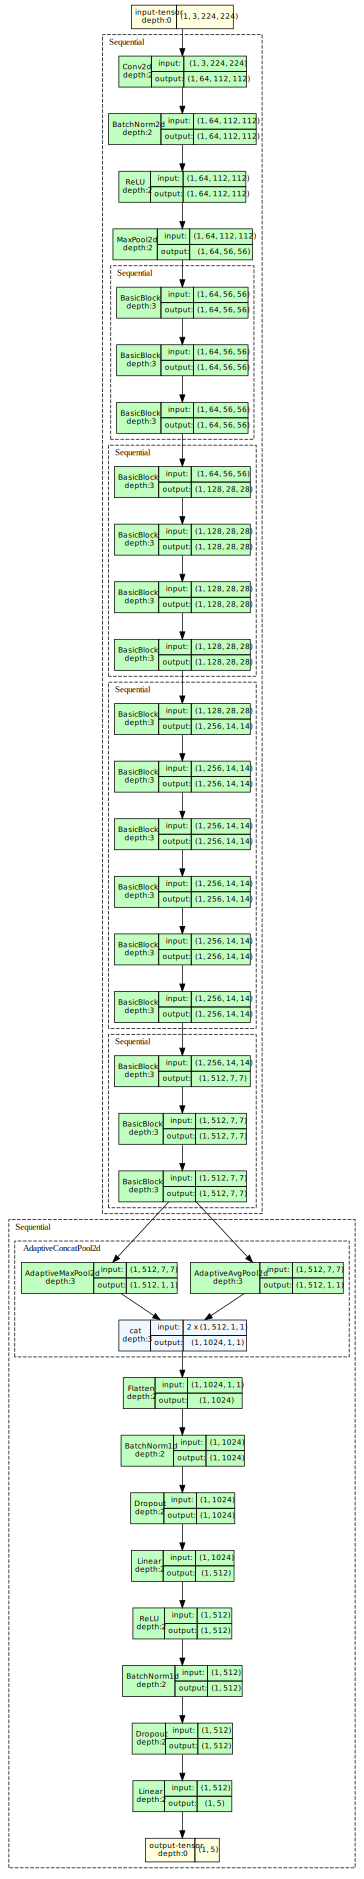

In [12]:
!pip -q install torchview graphviz

from torchview import draw_graph
import torch

model = learn.model.eval()
graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True)
graph.visual_graph.render(
    filename="model_graph",
    format="png",
    cleanup=True
)

graph.visual_graph